In [1]:
!pip install transformers datasets evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from datasets import load_dataset
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, TrainingArguments, Trainer
import numpy as np
import evaluate

In [3]:
# Load SQuAD datase
dataset = load_dataset("squad", split="train[:100%]")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [4]:
# Preprocessing function
def preprocess_function(examples, tokenizer):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length"
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions, end_positions = [], []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = start_char + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)
        idx = next((idx for idx, seq in enumerate(sequence_ids) if seq == 1), None)
        if idx is None:
            start_positions.append(0)
            end_positions.append(0)
            continue
        context_start = idx
        context_end = next(
            (idx for idx, seq in enumerate(sequence_ids[idx:], start=idx) if seq != 1),
            len(sequence_ids)
        ) - 1
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            try:
                start_idx = next(
                    idx for idx in range(context_start, context_end + 1)
                    if offset[idx][0] <= start_char and offset[idx][1] > start_char
                )
            except StopIteration:
                start_idx = 0
            try:
                end_idx = next(
                    idx for idx in range(context_end, context_start - 1, -1)
                    if offset[idx][1] >= end_char
                )
            except StopIteration:
                end_idx = 0

            start_positions.append(start_idx)
            end_positions.append(end_idx)

    inputs["start_positions"], inputs["end_positions"] = start_positions, end_positions
    return inputs

In [5]:
metric = evaluate.load("squad")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    start_logits, end_logits = predictions
    start_positions, end_positions = labels

    predicted_starts = np.argmax(start_logits, axis=1)
    predicted_ends = np.argmax(end_logits, axis=1)

    return {
        "start_accuracy": np.mean(predicted_starts == start_positions),
        "end_accuracy": np.mean(predicted_ends == end_positions)
    }

In [6]:
# minilm model
model_minilm = AutoModelForQuestionAnswering.from_pretrained("microsoft/MiniLM-L12-H384-uncased")
tokenizer_minilm = AutoTokenizer.from_pretrained("microsoft/MiniLM-L12-H384-uncased")

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [7]:
tokenized_dataset_minilm = dataset.map(lambda x: preprocess_function(x, tokenizer_minilm), batched=True, remove_columns=dataset.column_names)

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

In [8]:

training_args_minilm = TrainingArguments(
    output_dir="./results_minilm",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False
)

trainer_minilm = Trainer(
    model=model_minilm,
    args=training_args_minilm,
    train_dataset=tokenized_dataset_minilm,
    eval_dataset=tokenized_dataset_minilm,
    tokenizer=tokenizer_minilm,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-83c7c5825844>:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_minilm = Trainer(


In [9]:
trainer_minilm.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Start Accuracy,End Accuracy
1,0.498900,0.391566,0.757178,0.999098
2,0.430700,0.319534,0.792909,0.999087
3,0.345500,0.288587,0.809530,0.999121


TrainOutput(global_step=16425, training_loss=0.4855860378317637, metrics={'train_runtime': 2339.967, 'train_samples_per_second': 112.308, 'train_steps_per_second': 7.019, 'total_flos': 1.2893852094294528e+16, 'train_loss': 0.4855860378317637, 'epoch': 3.0})

In [10]:
trainer_minilm.evaluate()

{'eval_loss': 0.28858745098114014,
 'eval_start_accuracy': 0.8095297891528442,
 'eval_end_accuracy': 0.9991209945319011,
 'eval_runtime': 205.3932,
 'eval_samples_per_second': 426.494,
 'eval_steps_per_second': 26.656,
 'epoch': 3.0}

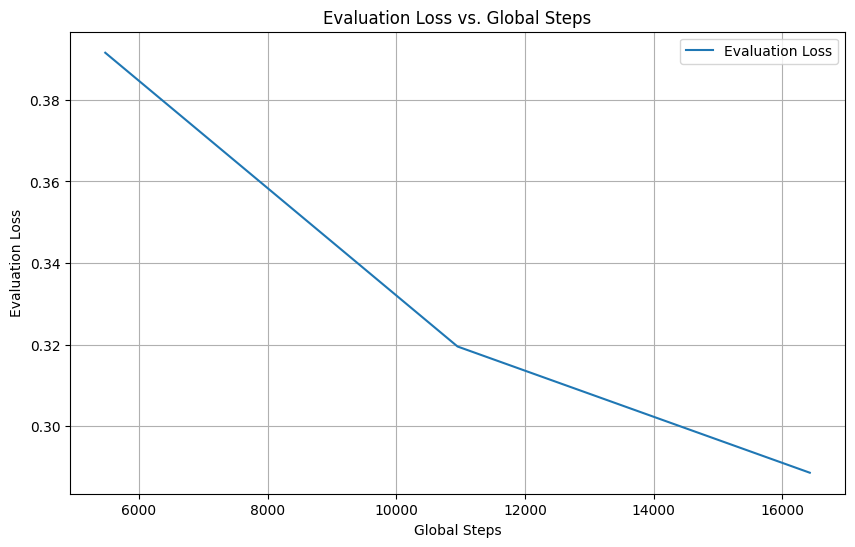

In [11]:
import matplotlib.pyplot as plt

log_history = trainer_minilm.state.log_history

#  evaluation loss and global steps
eval_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
global_steps = [log['step'] for log in log_history if 'eval_loss' in log]


# plot
plt.figure(figsize=(10, 6))
plt.plot(global_steps, eval_losses, label='Evaluation Loss')
plt.xlabel('Global Steps')
plt.ylabel('Evaluation Loss')
plt.title('Evaluation Loss vs. Global Steps')
plt.legend()
plt.grid(True)
plt.show()

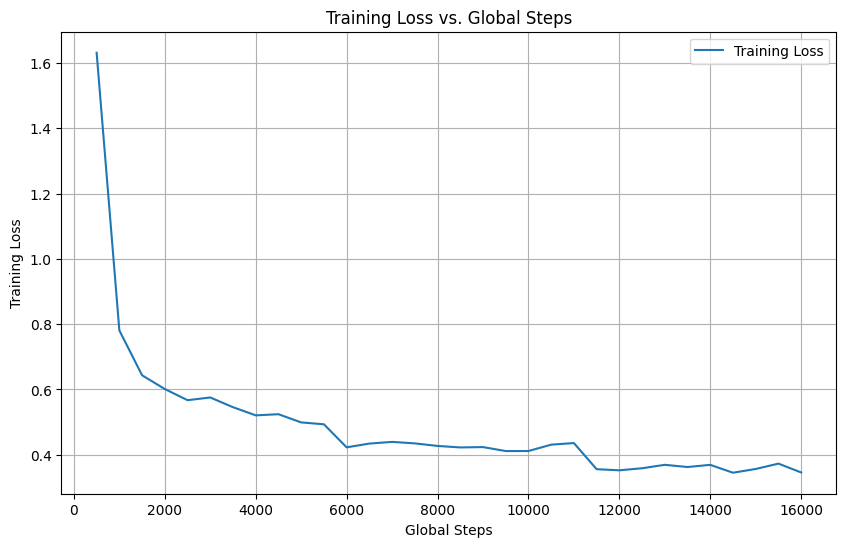

In [12]:

# training loss and global steps
train_losses = [log['loss'] for log in log_history if 'loss' in log]
global_steps = [log['step'] for log in log_history if 'loss' in log]


# plot
plt.figure(figsize=(10, 6))
plt.plot(global_steps, train_losses, label='Training Loss')
plt.xlabel('Global Steps')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Global Steps')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
trainer_minilm.save_model("/content/drive/MyDrive/minilm_model")

In [15]:
from transformers import pipeline


qa_model = pipeline("question-answering", model="/content/drive/MyDrive/minilm_model")

context = "My name is Wolfgang and I live in Berlin"
question = "Where do I live?"


Device set to use cuda:0


In [16]:
result = qa_model(question=question, context=context)
print(f"Answer: {result['answer']}")
print(f"Score: {result['score']}")

Answer: in Berlin
Score: 0.6892082691192627
